#### Library imports 

In [4]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import owslib.fes as fes
from owslib.etree import etree
from owslib.wfs import WebFeatureService
import geopandas as gpd
import shutil
import os
import zipfile
from osgeo import gdal, ogr, osr, gdal_array, gdalconst
from cartopy.feature import ShapelyFeature
from shapely.geometry import box

# GDAL Reprojection Tutorial

This Notebook is a tutorial on how to access, store, reproject and visualise a vector dataset from the EMODnet Human Activities Catalogue within an EDITO Service.

We start however by accessing the Zarr Bathymetric dataset from the EMODNet STAC Catalogue to use it as a basemap for creating our visualisation. And will later dive into working with vectorized data.

### Raster Bathymetric basemap access and initial inspection

In [5]:
#Path to Bathymetric dataset
host= 'https://s3.waw3-1.cloudferro.com'
bucket = 'emodnet'
arco_location = 'bathymetry/bathymetry_2022.zarr'

# open dataset
dataset = xr.open_dataset(f"{host}/{bucket}/{arco_location}", engine='zarr')
dataset.attrs

# Inspect the Elevation data 
elevation_data_array = dataset.data_vars['elevation']
print(elevation_data_array)

<xarray.DataArray 'elevation' (latitude: 72000, longitude: 75840)> Size: 22GB
[5460480000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 576kB 15.0 15.0 15.0 15.0 ... 90.0 90.0 90.0
  * longitude  (longitude) float64 607kB -36.0 -36.0 -36.0 ... 43.0 43.0 43.0
Attributes:
    grid_mapping:        crs
    long_name:           Elevation relative to sea level
    max:                 598.0
    min:                 -6912.60693359375
    sdn_parameter_name:  Sea-floor height (above Lowest Astronomical Tide dat...
    sdn_parameter_urn:   SDN:P01::HGHTALAT
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       geoid_height_above_reference_ellipsoid
    units:               m


### Open and Plot the Bathymetry raster data
Below we create an initial map of the bathymetry of the North Sea which will serve as our region of interest in this example. 

In [6]:
# Define bounding boxes for your desired region within European waters 
region = 'North Sea' 
bbox = (-2, 8, 50, 60)

# Subset the dataset within the specified bounding box
subset_dataset = dataset.sel(latitude=slice(bbox[2], bbox[3]), longitude=slice(bbox[0], bbox[1]))
elevation_data_subset = subset_dataset['elevation']
print(elevation_data_subset)                                                                        # Inspect the 'Elevation' data slice (subset)


<xarray.DataArray 'elevation' (latitude: 9600, longitude: 9600)> Size: 369MB
[92160000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 77kB 50.0 50.0 50.0 50.0 ... 60.0 60.0 60.0
  * longitude  (longitude) float64 77kB -1.999 -1.998 -1.997 ... 7.998 7.999
Attributes:
    grid_mapping:        crs
    long_name:           Elevation relative to sea level
    max:                 598.0
    min:                 -6912.60693359375
    sdn_parameter_name:  Sea-floor height (above Lowest Astronomical Tide dat...
    sdn_parameter_urn:   SDN:P01::HGHTALAT
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       geoid_height_above_reference_ellipsoid
    units:               m


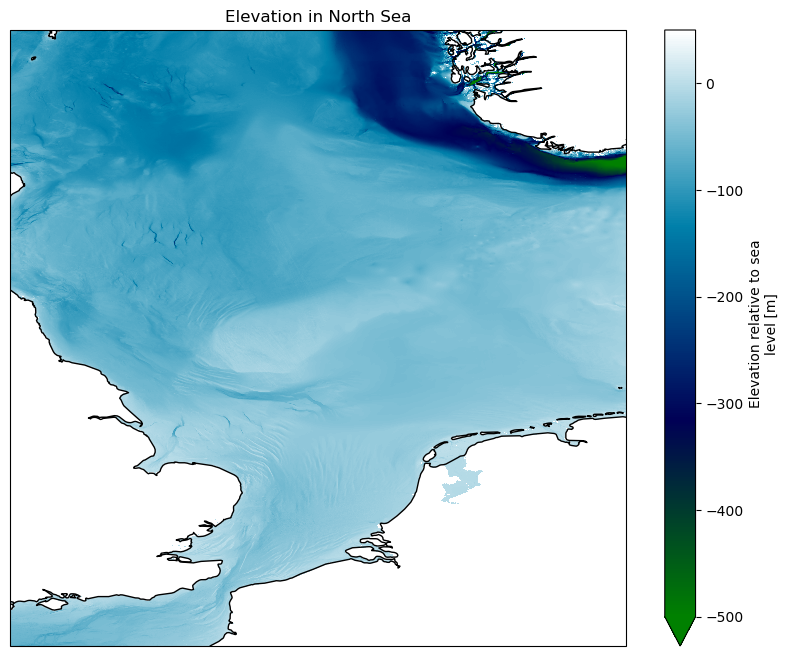

In [7]:
# Create a map using Cartopy
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([bbox[0], bbox[1], bbox[2], bbox[3]])

# Plot elevation data, specifying the color bar range and colormap
elevation_data_subset.plot(cmap = 'ocean', vmin=-500, vmax=50)  
plt.title(f"Elevation in {region}")

#Save the figure locally 
#plt.savefig(f'{region}_DTM.tif')                                                                   # Uncomment and specify your desired file location and name
plt.show()

Now, lets dive deeper into the interesting data. In this example we will access a vector dataset (a shapefile) of the Windfarm projects in the North Sea from the EMODNet Human Activities Catalogue. 

In particular, we will look into:
1. Where and how to access it.
2. How to download a compressed version of the shapefile and unpack it.
3. How to do some basic Geoprocessing using GDAL i.e. reproject the data to the desired EPSG.
4. How to plot the data on top of the bathymetric dataset opened above.


### 1. Loading and inspecting Vector data from EMODnet

In [8]:
# Create Directory to download the Vector data
downloads_dir = 'shp_dir'
os.makedirs(downloads_dir, exist_ok=True) #Local on the service

#Connect to the EMODnet Human Activities WebFeatureService and Inspect
wfs = WebFeatureService('https://ows.emodnet-humanactivities.eu/wfs', version = '1.1.0')
print(wfs.identification.type)
print(wfs.identification.version)
print(wfs.identification.title)
print(wfs.identification.abstract)

WFS
1.1.0
GeoServer Web Feature Service
This is the reference implementation of WFS 1.0.0 and WFS 1.1.0, supports all WFS operations including Transaction.


In [9]:
# OPTIONAL: Inspect available datasets 
list(wfs.contents)

['emodnet:activelicenses',
 'emodnet:advisorycouncils',
 'emodnet:aquaculture',
 'emodnet:baltic',
 'emodnet:blacksea',
 'emodnet:longdistancefleet',
 'emodnet:market',
 'emodnet:mediterranean',
 'emodnet:northsea',
 'emodnet:northwesternwaters',
 'emodnet:outermostregions',
 'emodnet:pelagicstocks',
 'emodnet:southwesternwaters',
 'emodnet:aggregateareas',
 'emodnet:aggregates',
 'emodnet:fishingbeamtrawls',
 'emodnet:fishingbottomottertrawls',
 'emodnet:fishingbottomseines',
 'emodnet:fishingdredges',
 'emodnet:fishingpelagic',
 'emodnet:fishingstaticgears',
 'emodnet:fishingsubsurface',
 'emodnet:fishingsurface',
 'emodnet:barcelona',
 'emodnet:hydrocarbons',
 'emodnet:bucharest',
 'emodnet:desalination',
 'emodnet:dischargepoints',
 'emodnet:dredgespoil',
 'emodnet:dredgespoilpoly',
 'emodnet:dredging',
 'emodnet:munitions',
 'emodnet:munitionspoly',
 'emodnet:emeraldnetwork',
 'emodnet:faoareas',
 'emodnet:finfish',
 'emodnet:fishsales',
 'emodnet:divisioncatches',
 'emodnet:major

### Define desired vector dataset
Lets inspect the Windfarms Polygons dataset which is a dataset of Windfarm projects in European waters.

In [10]:
dataset = 'emodnet:windfarmspoly'

#Inspect Windfarm polygons dataset
print(wfs.contents[dataset].title)
print(wfs.contents[dataset].abstract)

Wind Farms (Polygons)
The dataset on offshore wind farms in the European seas was created in 2014 by CETMAR for the European Marine Observation and Data Network (EMODnet). It is the result of the aggregation and harmonization of datasets provided by several sources. It is updated every year and it is available for viewing and download on EMODnet web portal (Human Activities, https://emodnet.ec.europa.eu/en/human-activities). The dataset contains points and/or (where available) polygons representing offshore wind farms in the following countries: Belgium, Denmark, Estonia, Finland, France, Germany, Greece, Ireland, Italy, Latvia, Lithuania, Netherlands, Norway, Poland, Portugal, Spain, Sweden and United Kingdom. Each point and polygon has the following attributes (where available): Name, Nº of turbines, Status (Approved, Planned, Dismantled, Construction, Production, Test site), Country, Year, Power (MW), Distance to coast (metres) and Area (square kilometres). The distance to coast (EE

#### Inspect the GeoJSON file by loading it into a geodataframe

In [11]:
response = wfs.getfeature(typename=dataset,
                          bbox=(bbox), #subset to the Study area ( based on bbox params)
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'shp_dir/{dataset.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'shp_dir/{dataset.replace(":","_")}.json')
gdf

,id,country,name,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,windfarmspoly.1,Sweden,Stora Middelgrund,108.0,864.0,Planned,None,24805.731113,59.826131,None,"MULTIPOLYGON (((12.03532 56.65295, 12.06134 56..."
1,windfarmspoly.2,Sweden,Lovstaviken,5.0,11.5,Production,None,0.000000,0.193854,None,"MULTIPOLYGON (((12.46710 56.89015, 12.47244 56..."
2,windfarmspoly.3,Sweden,Kattegatt Offshore,50.0,282.0,Approved,None,6381.649369,22.111037,None,"MULTIPOLYGON (((12.33361 56.86036, 12.34738 56..."
3,windfarmspoly.54,Denmark,Nissum Bredning,4.0,28.0,Production,2018,552.097064,1.033175,None,"MULTIPOLYGON (((8.23407 56.67252, 8.25175 56.6..."
4,windfarmspoly.55,Denmark,Horns Rev II,91.0,209.3,Production,2009,28725.073617,31.377920,None,"MULTIPOLYGON (((7.59319 55.64797, 7.59999 55.6..."
...,...,...,...,...,...,...,...,...,...,...,...
362,windfarmspoly.550,United Kingdom,Cenos,NaN,1350.0,Planned,None,187805.564816,332.902030,None,"MULTIPOLYGON (((1.40230 57.25235, 1.48642 57.2..."
363,windfarmspoly.559,United Kingdom,Salamander,NaN,100.0,Planned,None,33007.263264,33.243360,None,"MULTIPOLYGON (((-1.12492 57.61557, -1.20533 57..."
364,windfarmspoly.551,United Kingdom,Culzean,NaN,3.0,Planned,None,221021.383044,2.001045,None,"MULTIPOLYGON (((1.87627 57.19864, 1.87668 57.1..."
365,windfarmspoly.552,United Kingdom,Judy,NaN,15.0,Planned,None,259624.252434,8.045883,None,"MULTIPOLYGON (((2.27045 56.67040, 2.27103 56.6..."


###  2. Store and unpack compressed (.zip) datasets

In [12]:
# Define the output file paths on your service
temp_zip_file = 'shp_dir/temp_shapefile.zip'
temp_dir = 'shp_dir/temp_shapefile'
output_shapefile ='shp_dir/temp_shapefile/windfarmspolyPolygon.shp'

# Create temporary directories
os.makedirs(temp_dir, exist_ok=True)

# Download and save the shapefile zip
response = wfs.getfeature(typename=dataset, outputFormat='SHAPE-ZIP')
with open(temp_zip_file, 'wb') as temp_file:
    shutil.copyfileobj(response, temp_file)

# Extract the zip file
with zipfile.ZipFile(temp_zip_file, 'r') as zip_ref:
    extracted_files = zip_ref.namelist()
    print(extracted_files)
    # Check if the output shapefile already exists before extraction
    if not os.listdir(temp_dir):
        zip_ref.extractall(temp_dir)

# Read the GeoDataFrame from the extracted Shapefile
Study_area = gpd.read_file(output_shapefile)
Study_area.to_file(output_shapefile, driver='ESRI Shapefile')

['windfarmspolyPolygon.shx', 'windfarmspolyPolygon.shp', 'windfarmspolyPolygon.cst', 'windfarmspolyPolygon.prj', 'windfarmspolyPolygon.dbf']


### 3. Process the Shapefiles using GDAL
Here we reproject the shapefile to the correct coordinate reference system. This is relatively basic geoprocessing to inspect the capabilities of GDAL within the virtual machine.

In [13]:
%%time

# Create the local folder for the reprojected shapefiles
reprojected = 'shp_dir/Repro_windfarms/'
os.makedirs(reprojected, exist_ok=True) #Local on the service

# Define a reprojecting function
def reproject_shapefile(input_shapefile, reprojected, target_epsg):
    """ Reprojects a shapefile to the specified EPSG code.
    Args:
        input_shapefile (str): Path to the input shapefile.
        output_shapefile (str): Path to save the reprojected shapefile.
        target_epsg (int): Target EPSG code for the projection.
    Returns:
        None
    """
    input_ds = ogr.Open(input_shapefile)
    input_layer = input_ds.GetLayer()
    target_spatial_ref = osr.SpatialReference()
    target_spatial_ref.ImportFromEPSG(target_epsg)
    transform = osr.CoordinateTransformation(input_layer.GetSpatialRef(), target_spatial_ref)
    
    # Create or open the output datasource
    if not os.path.exists(reprojected):
        os.makedirs(reprojected)
    output_ds = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(reprojected)
    
    # Check if the layer already exists, and delete it if necessary
    layer_name = 'reprojected_shapefile'
    if output_ds.GetLayerByName(layer_name):
        output_ds.DeleteLayer(layer_name)
    
    # Create the output layer
    output_layer = output_ds.CreateLayer(layer_name, target_spatial_ref, geom_type=ogr.wkbPolygon)
    output_layer.CreateFields(input_layer.schema)
    
    for feature in input_layer:
        geometry = feature.GetGeometryRef()
        geometry.Transform(transform)
        new_feature = ogr.Feature(output_layer.GetLayerDefn())
        new_feature.SetGeometry(geometry)
        [new_feature.SetField(field.GetName(), feature.GetField(field.GetName())) for field in input_layer.schema]
        output_layer.CreateFeature(new_feature)
        new_feature = None
    
    input_ds = None
    output_ds = None

# Reproject the shapefile
reproject_shapefile(os.path.join(temp_dir,'windfarmspolyPolygon.shp'), reprojected, 4326)

CPU times: total: 93.8 ms
Wall time: 233 ms


### 3. Plotting the Windfarm shapefile as an overlay of the Bathymetry raster for visualisation

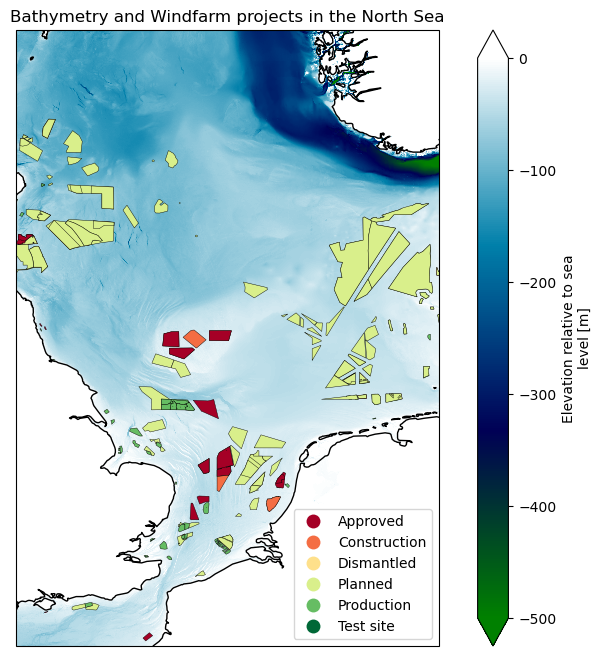

CPU times: total: 1min 37s
Wall time: 5min 42s


In [16]:
%%time

# Define bounding boxes for different regions within European waters
region = 'North Sea' 
bbox = (-2, 8, 50, 60)

# Plot on a map using Cartopy
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([bbox[0], bbox[1], bbox[2], bbox[3]])

# Read the reprojected shapefile into a GeoDataFrame
gdf_reprojected = gpd.read_file(reprojected)

# Plot elevation data with specific color bar range
elevation_data_subset.plot(cmap='ocean', vmin=-500, vmax=0, ax=ax)  # Set color bar range from 0 to 500 meters
# Plot the GeoDataFrame
gdf_reprojected.plot(column='status',                                       # Specify the column in which the data you need to plot is located
         categorical=False,
         cmap='RdYlGn',
         legend=True,
         legend_kwds={'loc': 'lower right'},
         alpha=1,
         edgecolor = 'black', 
         linewidth = 0.3,
         ax=ax) 

plt.title(f"Bathymetry and Windfarm projects in the {region}")

#Save the figure locally 
#plt.savefig(f'{region}.tif')
plt.show()
